# Manufacturing Efficiency Estimation Calculations

This notebook covers the calculations used to estimate the manufacturing efficiency of silicon for mono and mc Si modules. This data will be utilized in the baseline files for PV DEMICE.

NOTE: You must run Silicon per m2 journal before running this one, as the calculations depend on grams of silicon per cell.

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

In [34]:
#read in supporting csv files
cwd = os.getcwd() #grabs current working directory
si_g_percell = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/si_g_per_cell.csv", index_col='Year')
kerf_loss_raw = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/kerf_loss_microns.csv", index_col='Year')
utilize_gperwafer_raw = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/utilization_g_perwafer.csv", index_col='Year')
wafer_thickness = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/Wafer_thickness.csv", index_col='Year')
wafering_marketshare = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/wafering_marketshare.csv", index_col='Year')
marketshare_mono_mc = pd.read_csv(cwd+"/../../PV_DEMICE/baselines/SupportingMaterial/scaledmrktshr_mcSi_mono.csv", index_col='Year')

From the literature resources, we have data points that indicate a 50% input material waste for Silicon per cell prior to 2003. Therefore, we will assume a 50% manufacturing efficiency 1995 through 2003.

There is a derth of data 2004 through 2009.

As of 2010, ITRPV data provides kerf loss data, through 2017. This combined with wafer thickness, will be used as a proxy for mfg losses, combined with insights from the ITRPV "polysilicon utilization" data (which includes wafer thickness, kerf loss, crucible size, from squaring to cropping).

Similarly, as of 2017, ITRPV provides data on "polysilicon utilization", which is expressed as a number of grams of silicon used to make a wafer, and proken down by mono-Si vs. mc-Si and diamond wire vs. slurry cut, and includes projections out to 2030. This data will be utilized for 2017 onward to calculate % manufacturing efficiency relative to the average cell mass calculated by "Silicon g per m2" OR shold we use on a 10g/cell basis that ITRPV uses??

## 2010 through 2017

mfg efficiency by kerf loss proxy is calculated by:
            
            [Wafer Thickness/(Wafer Thickness + Kerf Loss)] * 100 = % mfg efficiency (proxy)

And the inverse or manufacturing inefficiency should be calculated by:

            [(Wafer Thickness + Kerf Loss)/Wafer Thickness] * 100 = % mfg "inefficeincy"

In [3]:
#There are missing data in wafer thickness, so we will interpolate linearly for missing years
wafer_thick = wafer_thickness.interpolate(method='linear',axis=0)

#Kerf loss also has missing data (projections), same linear interpolate
kerf_loss = kerf_loss_raw.interpolate(method='linear',axis=0, limit_area='inside')

#concat wafer thickness and kerf loss dfs together
df_thick_kerf = pd.concat([wafer_thick,kerf_loss], axis=1) #concatinate on the columns axis

#print(df_thick_kerf)

Because slurry and diamond have significantly different kerf losses, we will keep these seperate for as long as possible before averaging.

In [19]:
df_thick_kerf['slurry_eff'] = df_thick_kerf['wafer_thickness']/(df_thick_kerf['wafer_thickness']+df_thick_kerf['slurry'])
df_thick_kerf['diamond_eff'] = df_thick_kerf['wafer_thickness']/(df_thick_kerf['wafer_thickness']+df_thick_kerf['diamond'])
#for maths, create the "inefficiency" percentage by slurry and diamond
#i.e. this is how much extra material needed to be put in to get out a single wafer unit
df_thick_kerf['slurry_ineff'] = (df_thick_kerf['wafer_thickness']+df_thick_kerf['slurry'])/df_thick_kerf['wafer_thickness']
df_thick_kerf['diamond_ineff'] = (df_thick_kerf['wafer_thickness']+df_thick_kerf['diamond'])/df_thick_kerf['wafer_thickness']
print(df_thick_kerf)

      wafer_thickness  slurry     diamond  slurry_eff  diamond_eff  \
Year                                                                 
1990       400.000000     NaN         NaN         NaN          NaN   
1991       392.857143     NaN         NaN         NaN          NaN   
1992       385.714286     NaN         NaN         NaN          NaN   
1993       378.571429     NaN         NaN         NaN          NaN   
1994       371.428571     NaN         NaN         NaN          NaN   
1995       364.285714     NaN         NaN         NaN          NaN   
1996       357.142857     NaN         NaN         NaN          NaN   
1997       350.000000     NaN         NaN         NaN          NaN   
1998       342.857143     NaN         NaN         NaN          NaN   
1999       335.714286     NaN         NaN         NaN          NaN   
2000       328.571429     NaN         NaN         NaN          NaN   
2001       321.428571     NaN         NaN         NaN          NaN   
2002       314.28571

### 2017 check - compare kerf loss calc to ITRPV "utilization"

As a reality check, and because we have data for 2017 of both kerf loss and "utilization", we can check how good a proxy kerf loss is for utilization of input material.

In [7]:
#Multiply the proxy mfg efficiency by the averaged g/cell of silicon (as calculated by "Silicon per m2")
check2017_slurry = (si_g_percell['Si_gpercell'][2017])*(df_thick_kerf['slurry_ineff'][2017])
check2017_diamond = (si_g_percell['Si_gpercell'][2017])*(df_thick_kerf['diamond_ineff'][2017])

#Compare in a printed out table
data = {'Slurry':[check2017_slurry,utilize_gperwafer_raw['mc-Si-slurry'][2017],utilize_gperwafer_raw['mono-Si-slurry'][2017]],
        'Diamond':[check2017_diamond,utilize_gperwafer_raw['mc-Si-diamond'][2017],utilize_gperwafer_raw['Mono-Si-diamond'][2017]]}
gperwafer_compare = pd.DataFrame(data, index= ['Calculated','ITRPV_mc-Si','ITRPV_mono'])

print(gperwafer_compare)

                Slurry    Diamond
Calculated   17.414214  15.130383
ITRPV_mc-Si  19.500000  16.750000
ITRPV_mono   18.750000  15.700000


The calculated values based on just kerf loss are lower than ITRPV findings. This is unsurprising, since the ITRPV polysilicon utilization includes more than just kerf losses. We will compute the differences, and use this as a factor to add to all calculated values based on kerf loss alone.

In [18]:
#gperwafer_compared = gperwafer_compare.append(gperwafer_compare.diff()) 
    #diff compares to a prior or later row always relative to current index
calcd = gperwafer_compare.loc['Calculated']
gperwafer_factors = gperwafer_compare.sub(calcd)
print(gperwafer_factors)


               Slurry   Diamond
Calculated   0.000000  0.000000
ITRPV_mc-Si  2.085786  1.619617
ITRPV_mono   1.335786  0.569617


Now we will add these factors in and create a section of the final MFG losses (2010-2017).

In [46]:
#Multiply the proxy mfg inefficiency by the averaged g/cell of silicon (as calculated by "Silicon per m2")
#and add the 2017 computed factors, keeping mono and mc-Si separate.
slurry_mcSi_gpw = (si_g_percell['Si_gpercell']*df_thick_kerf['slurry_ineff'])+ gperwafer_factors['Slurry']['ITRPV_mc-Si']
slurry_mono_gpw = (si_g_percell['Si_gpercell']*df_thick_kerf['slurry_ineff'])+ gperwafer_factors['Slurry']['ITRPV_mono']
diamond_mcSi_gpw = (si_g_percell['Si_gpercell']*df_thick_kerf['diamond_ineff'])+ gperwafer_factors['Diamond']['ITRPV_mc-Si']
diamond_mono_gpw = (si_g_percell['Si_gpercell']*df_thick_kerf['diamond_ineff'])+ gperwafer_factors['Diamond']['ITRPV_mono']
mfg_losses_bytype = pd.concat([slurry_mcSi_gpw, slurry_mono_gpw, diamond_mcSi_gpw, diamond_mono_gpw], axis=1)
mfg_losses_bytype.columns = ['slurry_mcSi','slurry_mono','diamond_mcSi','diamond_mono']
print(mfg_losses_bytype)


      slurry_mcSi  slurry_mono  diamond_mcSi  diamond_mono
Year                                                      
1990          NaN          NaN           NaN           NaN
1991          NaN          NaN           NaN           NaN
1992          NaN          NaN           NaN           NaN
1993          NaN          NaN           NaN           NaN
1994          NaN          NaN           NaN           NaN
1995          NaN          NaN           NaN           NaN
1996          NaN          NaN           NaN           NaN
1997          NaN          NaN           NaN           NaN
1998          NaN          NaN           NaN           NaN
1999          NaN          NaN           NaN           NaN
2000          NaN          NaN           NaN           NaN
2001          NaN          NaN           NaN           NaN
2002          NaN          NaN           NaN           NaN
2003          NaN          NaN           NaN           NaN
2004          NaN          NaN           NaN           N

Because the market shares of slurry + diamond sum to 1 for each mono and mcSi, we will first weight (multiply and sum) the grams per wafer by technology. i.e. slurry_mcSi and diamond_mcSi will be combined.

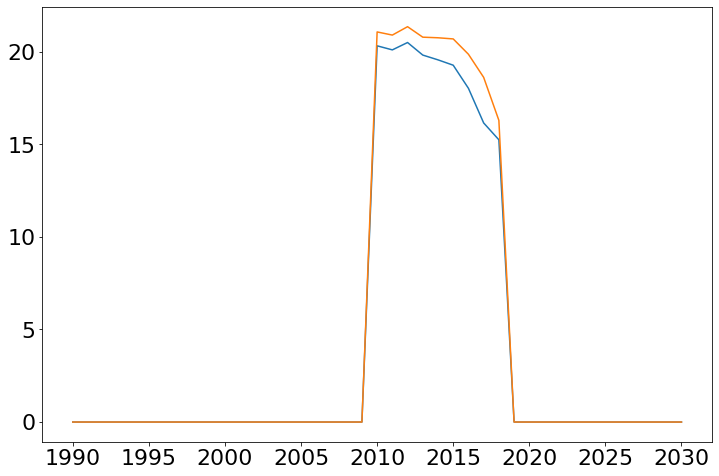

In [62]:
#Now weight the data by marketshare of type of cut
#Convert wafering marketshares to percentages for multiplication, and interpolate for the missing year
wafering_mrktshr = wafering_marketshare/100
wafering_mrktshr = wafering_mrktshr.interpolate(method='linear',axis=0, limit_area='inside')
#print(wafering_mrktshr)

#set column names identical for multiplying
mfg_losses_bytype.columns = wafering_mrktshr.columns = mfg_losses_bytype.keys()
mfg_losses_wtd = wafering_mrktshr.mul(mfg_losses_bytype, 'columns')

#combine by tech type (mono vs. mc-Si)
mfg_losses_wtd_mcSi = mfg_losses_wtd.filter(regex = 'mcSi')
mfg_losses_mcSi = pd.DataFrame(mfg_losses_wtd_mcSi.agg("sum", axis="columns"))
mfg_losses_mcSi.columns = ['mcSi_gpw']

mfg_losses_wtd_mono = mfg_losses_wtd.filter(regex = 'mono')
mfg_losses_mono = pd.DataFrame(mfg_losses_wtd_mono.agg("sum", axis="columns"))
mfg_losses_mono.columns = ['mono_gpw']

#combine into a single dataframe
gpw_cutwtd = pd.concat([mfg_losses_mono,mfg_losses_mcSi], axis=1)
gpw_cutwtd.columns = ['monoSi', 'mcSi']
plt.plot(gpw_cutwtd)
#print(gpw_cutwtd)

Now that we have a grams per wafer based on cut type for each PV tech type (mono vs mcSi), we will weight these data by the marketshare of installed PV type, creating an average module for the year.

Text(0, 0.5, 'Grams of Silicon per cell')

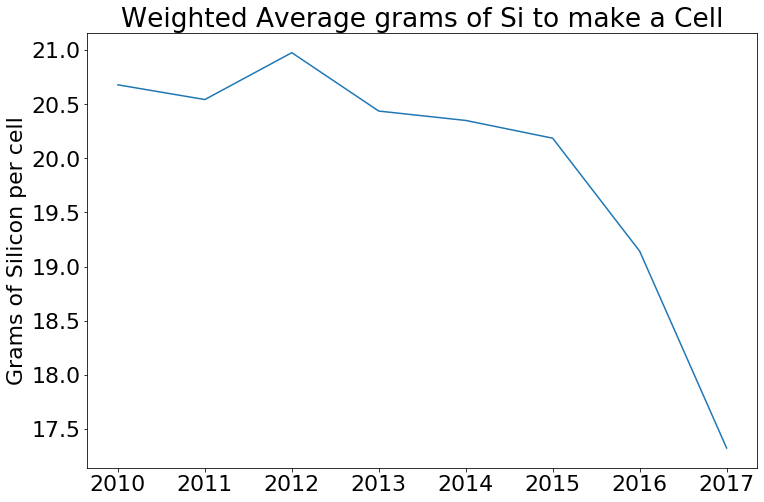

In [88]:
#Now weight by marketshare of mcSi vs Mono Si installed/made, as based on the silicon per m2 journal
#CAUTION: This is a lot of market weighting and averaging - may obsecure original data
gpw = gpw_cutwtd.mul(marketshare_mono_mc, 'columns')
gpw_avg = pd.DataFrame(gpw.agg("sum", axis="columns"))
gpw_avg.columns = ['avg_g_per_wafer']

#slice the dataframe for the relevant years and plot
gpw_avg_2010_2017 = gpw_avg.loc[(gpw_avg.index>=2010) & (gpw_avg.index<=2017)]
plt.plot(gpw_avg_2010_2017)
plt.title('Weighted Average grams of Si to make a Cell')
plt.ylabel('Grams of Silicon per cell')
#print(gpw_avg_2010_2017)

## 2017 through 2030

## 1995 through 2003

Here, as previously stated, we set 2003 and earlier years to 50% mfg efficiency

## 2004 through 2009

Until better data is found for this time period, simple linear interpolation will be used.